/tmp/ipykernel_51158/2190440439.py:28: RuntimeWarning: divide by zero encountered in divide
  term = np.sqrt(l / (p * one_minus_p)) * ((C - R) / denom)


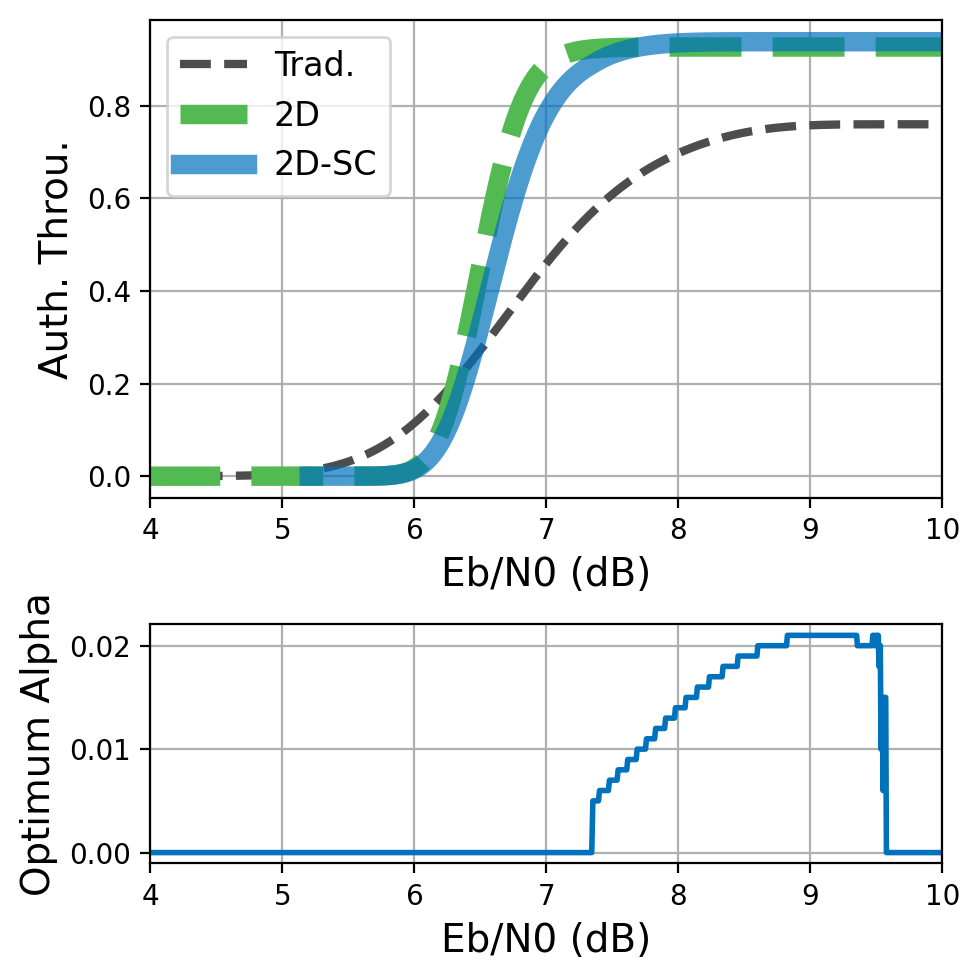

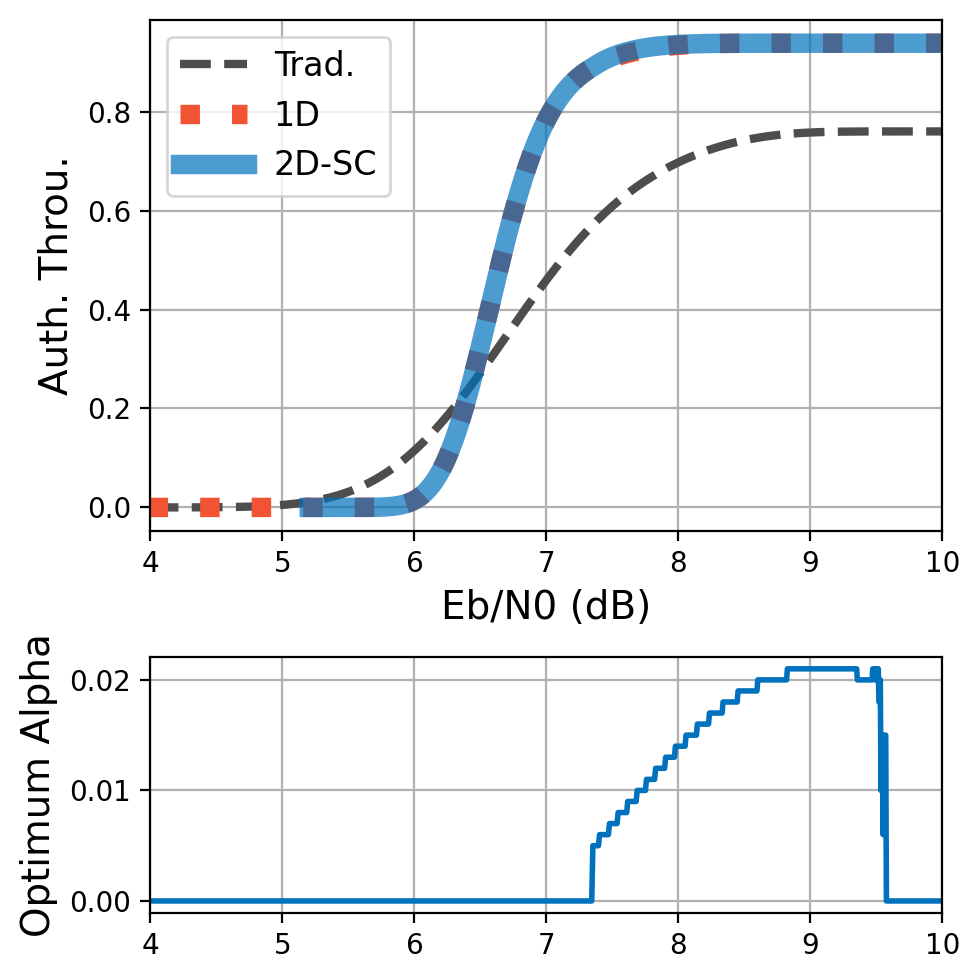

m = 538, t = 134, R = 0.95, nr = 20, nc = 20


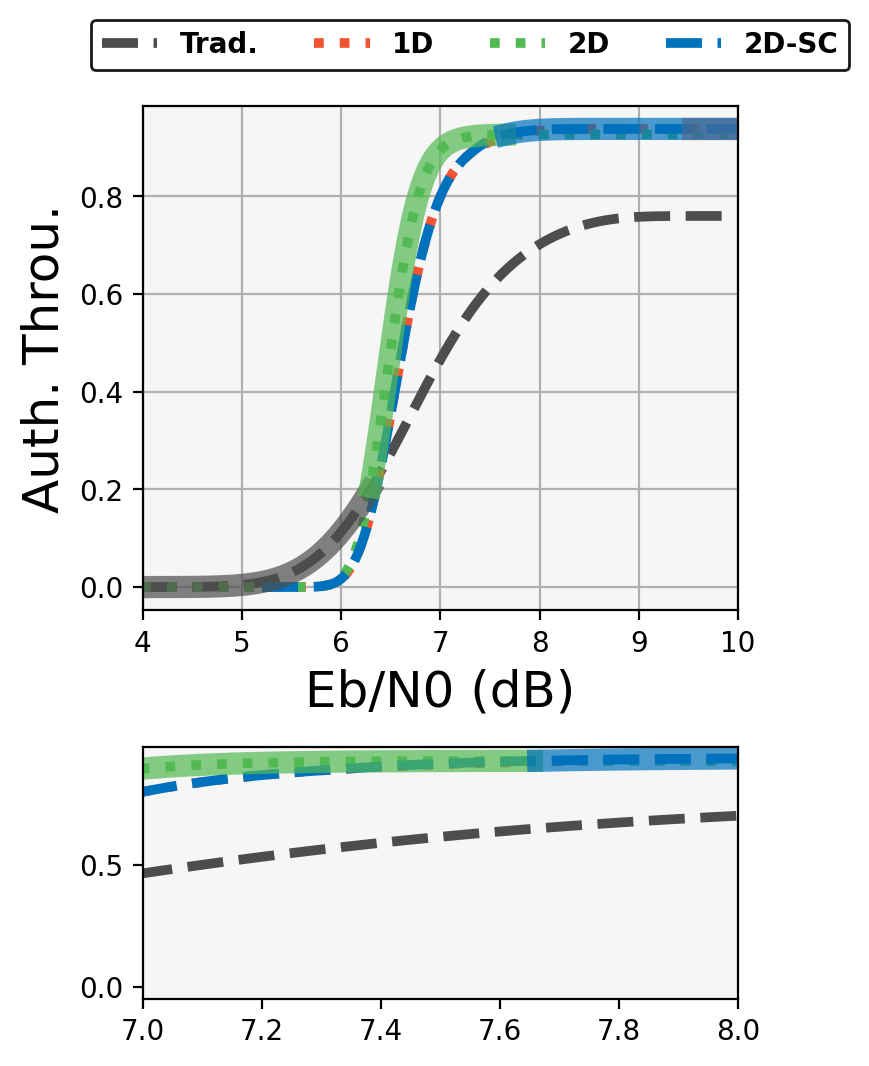

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Define Q-function
def qfunc(x):
    return 0.5 * erfc(x / np.sqrt(2))

# Basic SNR functions
def gam(txP, N0):
    return txP / N0

def gam_Super_tag(txP, N0, alpha):
    return (alpha * txP) / ((1 - alpha) * txP + N0)

def gam_Super_msg(txP, N0, alpha):
    return ((1 - alpha) * txP) / (alpha * txP + N0)

# Error rate function
def error_rate(l, R, snr):
    p = qfunc(np.sqrt(2 * snr))
    # Avoid log(0) issues by adding a very small number when needed.
    p = np.where(p == 0, 1e-22, p)
    one_minus_p = 1 - p
    C = 1 + p * np.log2(p) + one_minus_p * np.log2(one_minus_p)
    denom = np.log2(one_minus_p / p)
    term = np.sqrt(l / (p * one_minus_p)) * ((C - R) / denom)
    return qfunc(term)

# Functions for different processing schemes
def Pe_reg(l, P, R, N0):
    return error_rate(l, R, gam(P, N0))

def Pe_t_super(t, m, nc, P, R, N0, alpha):
    return error_rate(t, R * t / (nc * m), gam_Super_tag(P, N0, alpha))

def Pe_m_2D_super(m, R, P, N0, alpha):
    return error_rate(m, R, gam_Super_msg(P, N0, alpha))

# Energy per bit functions
def Em_trad(t, m, R, P):
    return P / R * (1 + t / m)

def Em_1D(t, m, R, P, nr):
    return P / R * (1 + t / (nr * m))

def Em_2D(t, m, R, P, nr, nc):
    return P / R * (1 + ((nr + nc) * t) / (nr * nc * m))

def Em_2D_super(t, m, R, P, nr):
    return P / R * (1 + t / (nr * m))

# Auxiliary functions for 2D schemes
def pr_2D(Pem, Pet, nr, nc):
    return (1 - ((1 - Pem)**(nc - 1) * (1 - Pet))) * (1 - ((1 - Pem)**(nr - 1) * (1 - Pet)))

def pr_2D_super(Pem, Pet, nr, nc, Pet_reg):
    return (1 - ((1 - Pem)**(nc - 1) * (1 - Pet))) * (1 - ((1 - Pem)**(nr - 1) * (1 - Pet_reg)))

# AER functions
def AER_trad(Pem, Pet):
    return 1 - ((1 - Pem) * (1 - Pet))

def AER_1D(Pem, Pet, nr):
    return 1 - (((1 - Pem)**nr) * (1 - Pet))

def AER_2D(Pem, Pet, nr, nc):
    return pr_2D(Pem, Pet, nr, nc) * (1 - Pem) + Pem

def AER_2D_super(Pem, Pet, nr, nc, Pet_reg):
    return pr_2D_super(Pem, Pet, nr, nc, Pet_reg) * (1 - Pem) + Pem

# Throughput functions
def AT_trad(Pem, Pet, m, t, R):
    return (R * m / (m + t)) * ((1 - Pet) * (1 - Pem))

def AT_1D(Pem, Pet, m, t, nr, R):
    return (R * nr * m / (nr * m + t)) * ((1 - Pet) * ((1 - Pem)**nr))

def AT_2D(Pem, Pet, m, t, nr, nc, R):
    return (R * nr * nc * m / (nr * nc * m + (nr + nc) * t)) * ((1 - pr_2D(Pem, Pet, nr, nc)) * (1 - Pem))

def AT_2D_super(Pem, Pet, m, t, nr, nc, Pet_reg, R):
    return (R * nr * m / (nr * m + t)) * ((1 - pr_2D_super(Pem, Pet, nr, nc, Pet_reg)) * (1 - Pem))


# Define color palette (each row is an RGB triplet)
lineColors = np.array([
    [0.3,    0.3,    0.3],    # gray
    [0.95,   0.325,  0.198],   # orange
    [0.325,  0.729,  0.325],   # green
    [0,      0.447,  0.741]    # blue
])



def find_optimal_alpha_and_plot_AT(P, N0, m, t, nr, nc):
    R_values = np.linspace(0.1, 1.0, 1000)  # Range of R values to evaluate
    alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)  # Range of alpha values

    max_AT_values_super = []  # To store maximum AT for 2D-super scheme
    optimal_alpha_values_super = []  # To store optimal alpha for 2D-super scheme

    max_AT_values_trad = []  # To store maximum AT for traditional scheme
    max_AT_values_1D = []  # To store maximum AT for 1D scheme
    max_AT_values_2D = []  # To store maximum AT for 2D scheme

    for R in R_values:
        # Compute AT for 2D-super scheme
        Pet_super = Pe_t_super(t, m, nc, P, R, N0, alpha_arr)
        Pem_super = Pe_m_2D_super(m, R, P, N0, alpha_arr)
        AT_values_super = AT_2D_super(Pem_super, Pet_super, m, t, nr, nc, Pe_reg(t, P, R, N0), R)

        # Find the maximum AT and corresponding alpha for 2D-super scheme
        max_AT_super = np.max(AT_values_super)
        optimal_alpha_super = alpha_arr[np.argmax(AT_values_super)]

        max_AT_values_super.append(max_AT_super)
        optimal_alpha_values_super.append(optimal_alpha_super)

        # Compute AT for traditional, 1D, and 2D schemes
        Pet_trad = Pe_reg(t, P, R, N0)
        Pem_trad = Pe_reg(m, P, R, N0)
        AT_trad_temp = AT_trad(Pem_trad, Pet_trad, m, t, R)
        max_AT_values_trad.append(AT_trad_temp)

        AT_1D_temp = AT_1D(Pem_trad, Pet_trad, m, t, nr, R)
        max_AT_values_1D.append(AT_1D_temp)

        AT_2D_temp = AT_2D(Pem_trad, Pet_trad, m, t, nr, nc, R)
        max_AT_values_2D.append(AT_2D_temp)

    # Plot AT vs R for all schemes
    plt.figure(figsize=(10, 6))
    plt.plot(R_values, max_AT_values_trad, label="Trad.", color=lineColors[0], linewidth=2)
    plt.plot(R_values, max_AT_values_1D, label="1D", color=lineColors[1], linewidth=2)
    plt.plot(R_values, max_AT_values_2D, label="2D", color=lineColors[2], linewidth=2)
    plt.plot(R_values, max_AT_values_super, label="2D-SC", color=lineColors[3], linewidth=2)
    plt.xlabel("R", fontsize=14)
    plt.ylabel("Max AT", fontsize=14)
    plt.title("Maximum AT vs R", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot optimal alpha vs R for 2D-super scheme
    plt.figure(figsize=(10, 6))
    plt.plot(R_values, optimal_alpha_values_super, label="Optimal Alpha (2D-SC)", color="blue", linewidth=2)
    plt.xlabel("R", fontsize=14)
    plt.ylabel("Optimal Alpha", fontsize=14)
    plt.title("Optimal Alpha vs R (2D-SC)", fontsize=16)
    plt.grid(True)
    plt.show()






def find_max_AT_vs_nr(P, N0, R, m, t, nc):
    """
    Find the maximum AT for different nr values from 1 to 1000 for all schemes.
    """
    nr_values = np.arange(1, 15)  # Range of nr values
    max_AT_trad = []  # To store maximum AT for traditional scheme
    max_AT_1D = []  # To store maximum AT for 1D scheme
    max_AT_2D = []  # To store maximum AT for 2D scheme
    max_AT_2D_super = []  # To store maximum AT for 2D-SC scheme

    for nr in nr_values:
        # Compute AT for traditional scheme
        Pet_trad = Pe_reg(t, P, R, N0)
        Pem_trad = Pe_reg(m, P, R, N0)
        AT_trad_temp = AT_trad(Pem_trad, Pet_trad, m, t, R)
        max_AT_trad.append(AT_trad_temp)

        # Compute AT for 1D scheme
        AT_1D_temp = AT_1D(Pem_trad, Pet_trad, m, t, nr, R)
        max_AT_1D.append(AT_1D_temp)

        # Compute AT for 2D scheme
        AT_2D_temp = AT_2D(Pem_trad, Pet_trad, m, t, nr, nc, R)
        max_AT_2D.append(AT_2D_temp)

        # Compute AT for 2D-SC scheme with the best alpha
        alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)
        Pet_super = Pe_t_super(t, m, nc, P, R, N0, alpha_arr)
        Pem_super = Pe_m_2D_super(m, R, P, N0, alpha_arr)
        AT_values_super = AT_2D_super(Pem_super, Pet_super, m, t, nr, nc, Pe_reg(t, P, R, N0), R)

        # Find the maximum AT and corresponding alpha for 2D-SC scheme
        max_AT_super = np.max(AT_values_super)
        max_AT_2D_super.append(max_AT_super)

    # Plot max AT vs nr for all schemes
    plt.figure(figsize=(10, 6))
    plt.plot(nr_values, max_AT_trad, label="Trad.", color=lineColors[0], linewidth=2)
    plt.plot(nr_values, max_AT_1D, label="1D", color=lineColors[1], linewidth=2)
    plt.plot(nr_values, max_AT_2D, label="2D", color=lineColors[2], linewidth=2)
    plt.plot(nr_values, max_AT_2D_super, label="2D-SC", color=lineColors[3], linewidth=2)
    plt.xlabel("nr", fontsize=14)
    plt.ylabel("Max AT", fontsize=14)
    plt.title("Maximum AT vs nr for All Schemes", fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()



def plot_AT_vs_nc(P, N0, R, m, t, nr):
    """
    Plot the AT for nc ranging from 1 to 1000 for all 4 schemes.
    """
    nc_values = np.arange(1, 15)  # Range of nc values
    max_AT_trad = []  # To store AT for traditional scheme
    max_AT_1D = []  # To store AT for 1D scheme
    max_AT_2D = []  # To store AT for 2D scheme
    max_AT_2D_super = []  # To store AT for 2D-SC scheme

    for nc in nc_values:
        # Compute AT for traditional scheme
        Pet_trad = Pe_reg(t, P, R, N0)
        Pem_trad = Pe_reg(m, P, R, N0)
        AT_trad_temp = AT_trad(Pem_trad, Pet_trad, m, t, R)
        max_AT_trad.append(AT_trad_temp)

        # Compute AT for 1D scheme
        AT_1D_temp = AT_1D(Pem_trad, Pet_trad, m, t, nr, R)
        max_AT_1D.append(AT_1D_temp)

        # Compute AT for 2D scheme
        AT_2D_temp = AT_2D(Pem_trad, Pet_trad, m, t, nr, nc, R)
        max_AT_2D.append(AT_2D_temp)

        # Compute AT for 2D-SC scheme with the best alpha
        alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)
        Pet_super = Pe_t_super(t, m, nc, P, R, N0, alpha_arr)
        Pem_super = Pe_m_2D_super(m, R, P, N0, alpha_arr)
        AT_values_super = AT_2D_super(Pem_super, Pet_super, m, t, nr, nc, Pe_reg(t, P, R, N0), R)

        # Find the maximum AT for 2D-SC scheme
        max_AT_super = np.max(AT_values_super)
        max_AT_2D_super.append(max_AT_super)

    # Plot AT vs nc for all schemes
    plt.figure(figsize=(10, 6))
    plt.plot(nc_values, max_AT_trad, label="Trad.", color=lineColors[0], linewidth=2)
    plt.plot(nc_values, max_AT_1D, label="1D", color=lineColors[1], linewidth=2)
    plt.plot(nc_values, max_AT_2D, label="2D", color=lineColors[2], linewidth=2)
    plt.plot(nc_values, max_AT_2D_super, label="2D-SC", color=lineColors[3], linewidth=2)
    plt.xlabel("nc", fontsize=14)
    plt.ylabel("AT", fontsize=14)
    plt.title("AT vs nc for All Schemes", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Example usage
























def plot(P_arr, R, m, t, N0, nr, nc, xlimit = None, xlimitAER = None, ylimit = None, ylimitAER = None): 
    # Define the range for Po and alpha

    alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)  # shape (n_alpha,)

    # Compute baseline error probabilities (with alpha = 0)
    Pet = Pe_reg(t, P_arr, R, N0)  # shape (nP,)
    Pem = Pe_reg(m, P_arr, R, N0)  # shape (nP,)

    # Prepare expanded arrays for vectorized computation over P and alpha.
    # P_exp: shape (nP, 1) and alpha_exp: shape (1, n_alpha)
    P_exp = P_arr[:, None]
    alpha_exp = alpha_arr[None, :]

    # Compute 2D-super values over the grid of P and alpha
    Pem_super_vec = Pe_m_2D_super(m, R, P_exp, N0, alpha_exp)  # shape (nP, n_alpha)
    Pet_super_vec = Pe_t_super(t, m, nc, P_exp, R, N0, alpha_exp)  # shape (nP, n_alpha)

    # Compute error rate and throughput for the 2D-super scheme.
    # Note: The baseline Pet (computed with alpha=0) is broadcast along axis 1.
    error_rate_2D_super_vec = AER_2D_super(Pem_super_vec, Pet_super_vec, nr, nc, Pet[:, None])
    throughput_2D_super_vec   = AT_2D_super(Pem_super_vec, Pet_super_vec, m, t, nr, nc, Pet[:, None], R)

    # For each Po value, select the optimal alpha values:
    # For minimum AER, ignore entries where error_rate == 1 by replacing them with np.inf.
    masked_AER = np.where(np.isclose(error_rate_2D_super_vec, 1), np.inf, error_rate_2D_super_vec)
    min_AER = np.min(masked_AER, axis=1)
    min_AER_idx = np.argmin(masked_AER, axis=1)
    min_AER_alpha = alpha_arr[min_AER_idx]

    # For maximum throughput, ignore zeros by replacing them with -infinity.
    masked_throughput = np.where(np.isclose(throughput_2D_super_vec, 0), -np.inf, throughput_2D_super_vec)
    max_Throu = np.max(masked_throughput, axis=1)
    max_Throu_idx = np.argmax(masked_throughput, axis=1)
    max_Throu_alpha = alpha_arr[max_Throu_idx]

    # Compute energy, error rate and throughput for the other schemes (all vectorized over P_arr)
    Eb_trad = Em_trad(t, m, R, P_arr)
    Throu_trad = AT_trad(Pem, Pet, m, t, R)

    Eb_1D = Em_1D(t, m, R, P_arr, nr)
    Throu_1D = AT_1D(Pem, Pet, m, t, nr, R)

    Eb_2D = Em_2D(t, m, R, P_arr, nr, nc)
    Throu_2D = AT_2D(Pem, Pet, m, t, nr, nc, R)

    Eb_2D_super = Em_2D_super(t, m, R, P_arr, nr)

    # ----- Plotting -----

    x_trad      = 10 * np.log10(Eb_trad      / N0)
    x_1D        = 10 * np.log10(Eb_1D        / N0)
    x_2D        = 10 * np.log10(Eb_2D        / N0)
    x_2D_super  = 10 * np.log10(Eb_2D_super  / N0)

    y_trad      = Throu_trad
    y_1D        = Throu_1D
    y_2D        = Throu_2D
    y_2D_super  = max_Throu   # 2D-SC 

    def bold_thin(
        x_main, y_main,
        x_other1, y_other1,
        x_other2, y_other2,
        x_other3, y_other3
    ):
        """
        For each point in (x_main, y_main), interpolate the other three curves at x_main[i].
        Then check if y_main[i] is >= all interpolated values.
        Return two arrays: y_main_bold, y_main_thin
        - y_main_bold is y_main where it is max, else NaN
        - y_main_thin is y_main where it is not max, else NaN
        """
        y_main_bold = np.full_like(y_main, np.nan)
        y_main_thin = np.full_like(y_main, np.nan)

        for i in range(len(x_main)):
            xx = x_main[i]
            val_main = y_main[i]

            # Interpolate each other curve at x_main[i]
            val_o1 = np.interp(xx, x_other1, y_other1)
            val_o2 = np.interp(xx, x_other2, y_other2)
            val_o3 = np.interp(xx, x_other3, y_other3)

            # Check if current point is >= all other values
            if val_main >= val_o1 and val_main >= val_o2 and val_main >= val_o3:
                y_main_bold[i] = val_main
            else:
                y_main_thin[i] = val_main

        return y_main_bold, y_main_thin

    # Create bold/thin arrays for each scheme
    y_trad_bold, y_trad_thin     = bold_thin(x_trad,  y_trad,  x_1D,   y_1D,   x_2D,   y_2D,   x_2D_super, y_2D_super)
    y_1D_bold,   y_1D_thin       = bold_thin(x_1D,    y_1D,    x_trad, y_trad, x_2D,   y_2D,   x_2D_super, y_2D_super)
    y_2D_bold,   y_2D_thin       = bold_thin(x_2D,    y_2D,    x_trad, y_trad, x_1D,   y_1D,   x_2D_super, y_2D_super)
    y_2Dsc_bold, y_2Dsc_thin     = bold_thin(x_2D_super,  y_2D_super,  x_trad, y_trad, x_1D,   y_1D,   x_2D,   y_2D)

    # Now we can plot them: thin first, then bold on top

    fig, axs = plt.subplots(2, 1, figsize=(4, 5), gridspec_kw={'height_ratios': [2, 1]}, dpi = 200)

    # Setting Background colour yellow 
    axs[0].set_facecolor(bgc)
    # Thin lines
    axs[0].plot(x_trad,  y_trad,        "--", color=lineColors[0],  linewidth=3.5, markersize=3, label="Trad.")
    axs[0].plot(x_1D,    y_1D,          ":",color=lineColors[1], linewidth=3.5, markersize=3, label="1D")
    axs[0].plot(x_2D,    y_2D,         ":", color=lineColors[2],  linewidth=3.5, markersize=3, label="2D")
    axs[0].plot(x_2D_super,  y_2D_super,       "--",color=lineColors[3],   linewidth=3.5, markersize=3, label="2D-SC")

    # Bold lines
    # # (No labels here to avoid duplicate legend entries.)
    axs[0].plot(x_trad,        y_trad_bold,     color=lineColors[0],  linewidth=8.0, markersize=15,  alpha=0.7)
    axs[0].plot(x_1D,          y_1D_bold,         color=lineColors[1],  linewidth=8.0, markersize=15,  alpha=0.7)
    axs[0].plot(x_2D,          y_2D_bold,         color=lineColors[2],  linewidth=8.0, markersize=15, alpha=0.7)
    axs[0].plot(x_2D_super,    y_2Dsc_bold,      color=lineColors[3],  linewidth=8.0, markersize=15,  alpha=0.7)

    axs[0].grid(True)

    if xlimit is not None:
        axs[0].set_xlim(xlimit)
    if ylimit is not None:
        axs[0].set_ylim(ylimit)
    
    axs[0].set_xlabel("Eb/N0 (dB)" ,fontsize = 18)
    axs[0].set_ylabel("Auth. Throu.",fontsize = 18)

    # axins = zoomed_inset_axes(axs[0], zoom=4, loc='center right', borderpad=-10.1)  
    # # zoom=2.0 is just an example; you can adjust as needed.

    # # 2. Re-plot the same lines/data on axins
    # axins.set_facecolor(bgc)
    # # Thin lines
    # axins.plot(x_trad,  y_trad,        "--", color=lineColors[0],  linewidth=3.5, markersize=3, label="Trad.")
    # axins.plot(x_1D,    y_1D,          ":",color=lineColors[1], linewidth=3.5, markersize=3, label="1D")
    # axins.plot(x_2D,    y_2D,         "--", color=lineColors[2],  linewidth=3.5, markersize=3, label="2D")
    # axins.plot(x_2D_super,  y_2D_super,       "--",color=lineColors[3],   linewidth=3.5, markersize=3, label="2D-SC")

    # # Bold lines
    # axins.plot(x_trad,        y_trad_bold,     color=lineColors[0],  linewidth=8.0, markersize=15,  alpha=0.7)
    # axins.plot(x_1D,          y_1D_bold,         color=lineColors[1],  linewidth=8.0, markersize=15,  alpha=0.7)
    # axins.plot(x_2D,          y_2D_bold,         color=lineColors[2],  linewidth=8.0, markersize=15, alpha=0.7)
    # axins.plot(x_2D_super,    y_2Dsc_bold,       color=lineColors[3],  linewidth=8.0, markersize=15,  alpha=0.7)

    # # 3. Set the inset limits
    # axins.set_xlim(7.2, 7.8)
    # axins.set_ylim(.89, R + .01 * R)

    # # Hide xticks and yticks
    # axins.set_xticks([])
    # axins.set_yticks([])

    # # 4. Draw lines connecting the inset region to the main axes
    # mark_inset(axs[0], axins, loc1= 3, loc2=4, fc="none", ec="0.5")
    # Add a legend on top of the figure

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, frameon=True, framealpha=0.9, edgecolor='black', bbox_to_anchor=(0.6, 1.07), prop={'weight': 'bold', 'size': 10})

    # # Setting Background colour yellow 
    # axs[1].set_facecolor(bgc)
    # axs[1].plot(10 * np.log10(Eb_2D_super / N0), max_Throu_alpha, '--',
    #         linewidth=5.5, color=lineColors[3])
    # axs[1].set_xlabel("Eb/N0 (dB)",fontsize = 22)
    # axs[1].set_ylabel(r'$\alpha$ (max Throu.)',fontsize = 22)
    # axs[1].set_xlim(xlimit)
    # axs[1].grid(True)


    axs[1].set_facecolor(bgc)
    # Thin lines
    axs[1].plot(x_trad,  y_trad,        "--", color=lineColors[0],  linewidth=3.5, markersize=3, label="Trad.")
    axs[1].plot(x_1D,    y_1D,          ":",color=lineColors[1], linewidth=3.5, markersize=3, label="1D")
    axs[1].plot(x_2D,    y_2D,         ":", color=lineColors[2],  linewidth=3.5, markersize=3, label="2D")
    axs[1].plot(x_2D_super,  y_2D_super,       "--",color=lineColors[3],   linewidth=3.5, markersize=3, label="2D-SC")

    # Bold lines
    # # (No labels here to avoid duplicate legend entries.)
    axs[1].plot(x_trad,        y_trad_bold,     color=lineColors[0],  linewidth=8.0, markersize=15,  alpha=0.7)
    axs[1].plot(x_1D,          y_1D_bold,         color=lineColors[1],  linewidth=8.0, markersize=15,  alpha=0.7)
    axs[1].plot(x_2D,          y_2D_bold,         color=lineColors[2],  linewidth=8.0, markersize=15, alpha=0.7)
    axs[1].plot(x_2D_super,    y_2Dsc_bold,      color=lineColors[3],  linewidth=8.0, markersize=15,  alpha=0.7)

    axs[1].set_xlim(7, 8)
    # axs[1].set_ylim(.89, R + .001 * R)

    print(f"m = {int(m)}, t = {int(t)}, R = {R}, nr = {nr}, nc = {nc}")
    plt.tight_layout()
    plt.show()


def plot_AT_vs_t_for_given_m(m, P, N0, R, nr, nc, xlimit=None, ylimit=None):
    """
    Plot the AT for t ranging from 0 up to m for all 4 schemes.
    """
    t_values = np.arange(0, m + 1, 1)  # Range of t values
    max_AT_trad = []  # To store AT for traditional scheme
    max_AT_1D = []  # To store AT for 1D scheme
    max_AT_2D = []  # To store AT for 2D scheme
    max_AT_2D_super = []  # To store AT for 2D-SC scheme

    for t in t_values:
        # Compute AT for traditional scheme
        Pet_trad = Pe_reg(t, P, R, N0)
        Pem_trad = Pe_reg(m, P, R, N0)
        AT_trad_temp = AT_trad(Pem_trad, Pet_trad, m, t, R)
        max_AT_trad.append(AT_trad_temp)

        # Compute AT for 1D scheme
        AT_1D_temp = AT_1D(Pem_trad, Pet_trad, m, t, nr, R)
        max_AT_1D.append(AT_1D_temp)

        # Compute AT for 2D scheme
        AT_2D_temp = AT_2D(Pem_trad, Pet_trad, m, t, nr, nc, R)
        max_AT_2D.append(AT_2D_temp)

        # Compute AT for 2D-SC scheme with the best alpha
        if R * t < R * m * nc:  # Ensure the condition for 2D-SC
            alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)
            Pet_super = Pe_t_super(t, m, nc, P, R, N0, alpha_arr)
            Pem_super = Pe_m_2D_super(m, R, P, N0, alpha_arr)
            AT_values_super = AT_2D_super(Pem_super, Pet_super, m, t, nr, nc, Pe_reg(t, P, R, N0), R)

            # Find the maximum AT for 2D-SC scheme
            max_AT_super = np.max(AT_values_super)
            max_AT_2D_super.append(max_AT_super)
        else:
            max_AT_2D_super.append(0)  # Set AT to 0 if condition is not met

    # Plot AT vs t for all schemes
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, max_AT_trad, label="Trad.", color=lineColors[0], linewidth=2)
    plt.plot(t_values, max_AT_1D, label="1D", color=lineColors[1], linewidth=2)
    plt.plot(t_values, max_AT_2D, label="2D", color=lineColors[2], linewidth=2)
    plt.plot(t_values, max_AT_2D_super, label="2D-SC", color=lineColors[3], linewidth=2)
    plt.xlabel("t", fontsize=14)
    plt.ylabel("AT", fontsize=14)
    plt.title(f"AT vs t for m = {m}", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    if xlimit is not None:
        plt.xlim(xlimit)
    if ylimit is not None:
        plt.ylim(ylimit)
    plt.show()


    # Example usage

def plot_AT_vs_m_for_given_t(t, P, N0, R, nr, nc, m_max=10000):
    """
    Plot the AT for m ranging from t up to m_max for all 4 schemes.
    """
    m_values = np.arange(t, m_max + 1, 1)  # Range of m values
    max_AT_trad = []  # To store AT for traditional scheme
    max_AT_1D = []  # To store AT for 1D scheme
    max_AT_2D = []  # To store AT for 2D scheme
    max_AT_2D_super = []  # To store AT for 2D-SC scheme
    best_alpha_2D_super = []  # To store the best alpha for 2D-SC scheme

    for m in m_values:
        # Compute AT for traditional scheme
        Pet_trad = Pe_reg(t, P, R, N0)
        Pem_trad = Pe_reg(m, P, R, N0)
        AT_trad_temp = AT_trad(Pem_trad, Pet_trad, m, t, R)
        max_AT_trad.append(AT_trad_temp)

        # Compute AT for 1D scheme
        AT_1D_temp = AT_1D(Pem_trad, Pet_trad, m, t, nr, R)
        max_AT_1D.append(AT_1D_temp)

        # Compute AT for 2D scheme
        AT_2D_temp = AT_2D(Pem_trad, Pet_trad, m, t, nr, nc, R)
        max_AT_2D.append(AT_2D_temp)

        # Compute AT for 2D-SC scheme with the best alpha
        alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)
        Pet_super = Pe_t_super(t, m, nc, P, R, N0, alpha_arr)
        Pem_super = Pe_m_2D_super(m, R, P, N0, alpha_arr)
        AT_values_super = AT_2D_super(Pem_super, Pet_super, m, t, nr, nc, Pe_reg(t, P, R, N0), R)

        # Find the maximum AT and corresponding alpha for 2D-SC scheme
        max_AT_super = np.max(AT_values_super)
        best_alpha = alpha_arr[np.argmax(AT_values_super)]
        max_AT_2D_super.append(max_AT_super)
        best_alpha_2D_super.append(best_alpha)

    # Plot AT vs m for all schemes
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

    # Upper 2/3: AT vs m
    axs[0].plot(m_values, max_AT_trad, label="Trad.", color=lineColors[0], linewidth=2)
    axs[0].plot(m_values, max_AT_1D, label="1D", color=lineColors[1], linewidth=2)
    axs[0].plot(m_values, max_AT_2D, label="2D", color=lineColors[2], linewidth=2)
    axs[0].plot(m_values, max_AT_2D_super, label="2D-SC", color=lineColors[3], linewidth=2)
    axs[0].set_xlabel("m", fontsize=14)
    axs[0].set_ylabel("AT", fontsize=14)
    axs[0].set_title(f"AT vs m for t = {t}", fontsize=16)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)

    # Lower 1/3: Best alpha vs m
    axs[1].plot(m_values, best_alpha_2D_super, label="Best Alpha (2D-SC)", color=lineColors[3], linewidth=2)
    axs[1].set_xlabel("m", fontsize=14)
    axs[1].set_ylabel("Best Alpha", fontsize=14)
    axs[1].set_title("Best Alpha vs m for 2D-SC", fontsize=16)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


    # Example usage



def compare_2Dsc_with_1D(P_arr, R, m, t, N0, nr, nc, xlimit=None, ylimit=None):
    """
    Compare the 2D-SC scheme with the 1D MAC scheme and plot AT vs P_arr.
    Optimize the 2D-SC scheme regarding alpha and plot the optimum alpha in a subplot.
    """
    # Define the range for alpha
    alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)

    # Compute baseline error probabilities (with alpha = 0)
    Pet = Pe_reg(t, P_arr, R, N0)  # shape (nP,)
    Pem = Pe_reg(m, P_arr, R, N0)  # shape (nP,)

    # Prepare expanded arrays for vectorized computation over P and alpha
    P_exp = P_arr[:, None]
    alpha_exp = alpha_arr[None, :]

    # Compute 2D-super values over the grid of P and alpha
    Pem_super_vec = Pe_m_2D_super(m, R, P_exp, N0, alpha_exp)  # shape (nP, n_alpha)
    Pet_super_vec = Pe_t_super(t, m, nc, P_exp, R, N0, alpha_exp)  # shape (nP, n_alpha)

    # Compute throughput for the 2D-super scheme
    throughput_2D_super_vec = AT_2D_super(Pem_super_vec, Pet_super_vec, m, t, nr, nc, Pet[:, None], R)

    # For each P value, select the optimal alpha values
    masked_throughput = np.where(np.isclose(throughput_2D_super_vec, 0), -np.inf, throughput_2D_super_vec)
    max_Throu = np.max(masked_throughput, axis=1)
    max_Throu_idx = np.argmax(masked_throughput, axis=1)
    max_Throu_alpha = alpha_arr[max_Throu_idx]

    # Compute throughput for the 1D MAC scheme
    Throu_1D = AT_1D(Pem, Pet, m, t, nr, R)

    # Plot AT vs P_arr for 2D-SC and 1D MAC
    fig, axs = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [2, 1]}, dpi=200)

    Eb_trad = Em_trad(t, m, R, P_arr)
    Throu_trad = AT_trad(Pem, Pet, m, t, R)

    Eb_1D = Em_1D(t, m, R, P_arr, nr)
    Throu_1D = AT_1D(Pem, Pet, m, t, nr, R)

    Eb_2D_super = Em_2D_super(t, m, R, P_arr, nr)

    x_trad = 10 * np.log10(Eb_trad / N0)
    x_1D = 10 * np.log10(Eb_1D / N0)

    x_2D_super = 10 * np.log10(Eb_2D_super / N0)

    # Upper 2/3: AT vs P_arr
    axs[0].plot(x_trad, Throu_trad,        '--', label="Trad.", color=lineColors[0], linewidth=3)
    axs[0].plot(x_1D, Throu_1D,            ':', label="1D", color=lineColors[1], linewidth=7)
    axs[0].plot(x_2D_super, max_Throu,     label="2D-SC", color=lineColors[3], linewidth=7, alpha = .7)

    axs[0].set_xlabel("Eb/N0 (dB)", fontsize=14)
    axs[0].set_ylabel("Auth. Throu.", fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)
    if xlimit is not None:
        axs[0].set_xlim(xlimit)
    if ylimit is not None:
        axs[0].set_ylim(ylimit)

    # Lower 1/3: Optimum alpha vs P_arr
    axs[1].plot(x_2D_super, max_Throu_alpha, label="Optimum Alpha (2D-SC)", color=lineColors[3], linewidth=2)
    axs[0].set_xlabel("Eb/N0 (dB)", fontsize=14)
    axs[1].set_ylabel("Optimum Alpha", fontsize=14)
    axs[1].grid(True)
    if xlimit is not None:
        axs[1].set_xlim(xlimit)

    plt.tight_layout()
    plt.show()



def compare_2Dsc_with_2D_and_trad(P_arr, R, m, t, N0, nr, nc, xlimit=None, ylimit=None):
    """
    Compare the 2D-SC scheme with the 2D and traditional schemes and plot AT vs P_arr.
    Optimize the 2D-SC scheme regarding alpha and plot the optimum alpha in a subplot.
    """
    # Define the range for alpha
    alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)

    # Compute baseline error probabilities (with alpha = 0)
    Pet = Pe_reg(t, P_arr, R, N0)  # shape (nP,)
    Pem = Pe_reg(m, P_arr, R, N0)  # shape (nP,)

    # Prepare expanded arrays for vectorized computation over P and alpha
    P_exp = P_arr[:, None]
    alpha_exp = alpha_arr[None, :]

    # Compute 2D-super values over the grid of P and alpha
    Pem_super_vec = Pe_m_2D_super(m, R, P_exp, N0, alpha_exp)  # shape (nP, n_alpha)
    Pet_super_vec = Pe_t_super(t, m, nc, P_exp, R, N0, alpha_exp)  # shape (nP, n_alpha)

    # Compute throughput for the 2D-super scheme
    throughput_2D_super_vec = AT_2D_super(Pem_super_vec, Pet_super_vec, m, t, nr, nc, Pet[:, None], R)

    # For each P value, select the optimal alpha values
    masked_throughput = np.where(np.isclose(throughput_2D_super_vec, 0), -np.inf, throughput_2D_super_vec)
    max_Throu = np.max(masked_throughput, axis=1)
    max_Throu_idx = np.argmax(masked_throughput, axis=1)
    max_Throu_alpha = alpha_arr[max_Throu_idx]

    # Compute throughput for the traditional and 2D schemes
    Throu_trad = AT_trad(Pem, Pet, m, t, R)
    Throu_2D = AT_2D(Pem, Pet, m, t, nr, nc, R)

    # Plot AT vs P_arr for 2D-SC, 2D, and traditional schemes
    fig, axs = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [2, 1]}, dpi=200)

    Eb_trad = Em_trad(t, m, R, P_arr)
    Eb_2D = Em_2D(t, m, R, P_arr, nr, nc)
    Eb_2D_super = Em_2D_super(t, m, R, P_arr, nr)

    x_trad = 10 * np.log10(Eb_trad / N0)
    x_2D = 10 * np.log10(Eb_2D / N0)
    x_2D_super = 10 * np.log10(Eb_2D_super / N0)

    # Upper 2/3: AT vs P_arr
    axs[0].plot(x_trad, Throu_trad,        '--', label="Trad.", color=lineColors[0], linewidth=3)
    axs[0].plot(x_2D, Throu_2D,            '--', label="2D", color=lineColors[2], linewidth=7)
    axs[0].plot(x_2D_super, max_Throu,     label="2D-SC", color=lineColors[3], linewidth=7, alpha=0.7)

    axs[0].set_xlabel("Eb/N0 (dB)", fontsize=14)
    axs[0].set_ylabel("Auth. Throu.", fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)
    if xlimit is not None:
        axs[0].set_xlim(xlimit)
    if ylimit is not None:
        axs[0].set_ylim(ylimit)

    # Lower 1/3: Optimum alpha vs P_arr
    axs[1].plot(x_2D_super, max_Throu_alpha, label="Optimum Alpha (2D-SC)", color=lineColors[3], linewidth=2)
    axs[1].set_xlabel("Eb/N0 (dB)", fontsize=14)
    axs[1].set_ylabel("Optimum Alpha", fontsize=14)
    axs[1].grid(True)
    if xlimit is not None:
        axs[1].set_xlim(xlimit)

    plt.tight_layout()
    plt.show()


xlimit = [4, 10]
# ylimit = [1/10**5, 10]



try:
    xlimit[0]
except:
    xlimit = None
try:
    xlimitAER[0]
except:
    xlimitAER = None
try:
    ylimit[0]
except:
    ylimit = None
try:
    ylimitAER[0]
except:
    ylimitAER = None


bgc = "#F6F6F6"

# # ----- Set parameters -----
# nr = 1000       # number of rows
# nc = 200        # number of columns
# R = 0.5
# N0 = 100
# P_arr = np.arange(1, 1700 + 1, .1)         # shape (nP,)
# for m, t in [(128, 128), (256, 128), (512, 128), (1024, 128), (2048, 128), (4096, 128) , (8192, 128)]:
#     plt.figure(figsize=(10, 8), dpi=200)
#     plot(P_arr, R, m/R, t/R, N0, nr, nc, xlimit, xlimitAER, ylimit, ylimitAER)



# # # ----- Set parameters -----
# nr = 4       # number of rows
# nc = 3        # number of columns

# m = 4096
# t = 256

# P =200
# N0 = 100
# # Example usage
# find_optimal_alpha_and_plot_AT(P=P, N0=N0, m=m, t=t, nr=nr, nc=nc)

# R = 0.5
# nc =3
# find_max_AT_vs_nr(P=P, N0=N0, R=R, m=m, t=t, nc=nc)

# R = 0.5
# nr =3
# plot_AT_vs_nc(P=P, N0=N0, R=R, m=m, t=t, nr=nr)


# m = 4096
# plot_AT_vs_t_for_given_m(m=m, P=P, N0=N0, R=R, nr=nr, nc=nc)


# t = 256
# plot_AT_vs_m_for_given_t(t=t, P=P, N0=N0, R=R, nr=nr, nc=nc)



# # ----- Set parameters -----
# nr = 15       # number of rows
# nc = 5        # number of columns
# R = 0.9
# N0 = 10
# P_arr = np.arange(0.1, 1700.1, .1)  # shape (nP,)
# # P_arr = np.unique(np.logspace(0, np.log10(170), num=1070, base=10, dtype=int))
# m  = 2000
# t =  128      



# nr = 15       # number of rows
# nc = 5        # number of columns
# R = 0.95
# N0 = 10
# P_arr = np.arange(0.1, 1700.1, .1)  # shape (nP,)
# # P_arr = np.unique(np.logspace(0, np.log10(170), num=1070, base=10, dtype=int))
# m  = 2500
# t =  128  



nr = 20      # number of rows
nc = 20        # number of columns
R = 0.95
N0 = 10
P_arr = np.arange(10, 170.1, .1)  # shape (nP,)
# P_arr = np.unique(np.logspace(0, np.log10(170), num=1070, base=10, dtype=int))
m  = 512
t =  128 
compare_2Dsc_with_2D_and_trad(P_arr, R, m, t, N0, nr, nc, xlimit=xlimit, ylimit=None)
compare_2Dsc_with_1D(P_arr, R, m, t, N0, nr, nc, xlimit, ylimit)
plot(P_arr, R, m/R, t/R, N0, nr, nc, xlimit, xlimitAER, ylimit, ylimitAER)
